## Metrics

***Offer just started***:

- customers using offer
    - total number : DONE
    - new -  % : DONE
    - existing - % : DONE
    - vs baseline (e.g how many new customers do you get in a typical <period of time>) : DONE (used week): issue = not many weeks before offer started to compare to? 
- Frequency of the redeeming group over customer type (new vs existing, how many times do they come)
    - Overall frequency : DONE for offer period
    - vs non-redeeming group: DONE for offer period
  
- % of new customers that have purchased again: DONE
- Revenue impact
    - Total
    - per customer
    - Value of discount
        - per customer
- ATV of the redeeming group over customer type (new & existing): DONE for offer period
    - Overall ATV: DONE for offer period
    - vs non-redeeming group: DONE for offer period
***Up to here***
- Basket size
- Time of day / day of week of redemption
    - New vs existing
- redemptions on the offer (if we've seen a customer redeem more than once - otherwise assume offers are single redemption per customer)
    - new
    - existing
    - by timeframe (e.g. day, week, month depending on length of offer)
- ~~Redemptions per location? (maybe out of scope)~~

***After x time***:

- Existing customers that fall into one of segments? E.G. are they changing groups (spending more)

***Post offer analysis***:

- Long-term impact on frequency of customers redeeming the offer
    - vs non-redeemers
- Long term impact of ATV of customers redeeming the offer
    - vs non-redeemers
- Retention of customers who have redeemed the offer vs baseline
- Segment of customers acquired via the offer
    - % in each segment vs expected %
- ~~Value of the customers acquired via the offer~~
    
    
***To decide***:
- what offer period should we be looking at? If offers go on forever not sure metrics will look right
    
***Thoughts***:
    
THink some histograms by date of new and existing customers are worth including as a sanity check
I got pretty far along with analysis before realising that all enw customers were coming throuhg on the first date.
Will be useful to have included in dashboard even if just as something descirptive and easy to produce to reduce risk. 

In [1]:
# install required packages
import pandas as pd
import numpy as np
from utils.database import query_from_file
import datetime
import time
import plotly.express as px
import psutil
from datetime import datetime, timedelta

path = '/Users/jennamiles/Documents/credentials'

/Users/jennamiles/.pyenv/versions/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
#this is from database.py
#need to update in utils because of directory issue
import os
from psycopg2 import connect
from pandas import read_sql

def query(sql_statement: str, **kwargs):
    with open(f'{path}', 'r') as credentials:
        connection = connect(credentials.read())
        cursor = connection.cursor()

        if len(kwargs) > 0:
            dataframe = read_sql(sql_statement.format(**kwargs), connection)
        else:
            dataframe = read_sql(sql_statement, connection)

        assert len(dataframe) > 0, 'query returned no results'
        return dataframe
    
def query_from_file(sql_file: str, **kwargs):
    with open(sql_file, 'r') as f:
        return query(f.read(), **kwargs)

In [3]:
#read in pure data from SQL query:\# read in the starling transacitons 
start = time.time()
df = query_from_file('pure_txns.sql')
end = time.time()
query_time = end-start
print(f"Query took {query_time:.2f} seconds")

Query took 8.33 seconds


In [4]:
df['transaction_date'].min()

Timestamp('2018-11-22 12:19:02.324000+0000', tz='UTC')

In [5]:
#additional date columns that will be useful 
df['date'] = df['transaction_date'].dt.date
df['day'] = df['transaction_date'].dt.isocalendar().day
df['week'] = df['transaction_date'].dt.isocalendar().week
df['week_start'] = (df['transaction_date'] - pd.TimedeltaIndex(df['transaction_date'].dt.dayofweek, unit='D')).dt.date
df['month'] = df['transaction_date'].dt.month

In [6]:
#other amendments needed = price is not numeric currently 
df['price'] = pd.to_numeric(df['item_price'])

In [7]:
#make a receipt count on all Pure transactions so we can tell if the offer txn was first with retailer
#warning: only can tell if first using flux 
df_receipts = df[['customer_id','receipt_id','total_amount','transaction_date','date','month','week','location_id']].drop_duplicates().sort_values(['customer_id','transaction_date'])
df_receipts['count'] = df_receipts.groupby(['customer_id'])['receipt_id'].cumcount()+1

In [8]:
#offer transactions = where money taken off receipt
offer_txns = df[df['price']<0].copy()

In [9]:
#pick an offer to use with highest volume
offer_txns.groupby(['name']).nunique().sort_values(by = 'customer_id', ascending = False)['customer_id'].head(10)

name
Reusable Cup 12oz                     530
High Protein Chilli TA                328
Reusable Cup 8oz                      286
Thai Red Chicken TA                   232
Eat Out to Help Out discount for 1    181
Free Coffee YELLOW                    157
Free Coffee                           149
Butternut Rendang TA                  129
Malay Chicken Curry TA                121
Free Coffee BLUE                       79
Name: customer_id, dtype: int64

In [10]:
df.date.min()

datetime.date(2018, 11, 22)

In [11]:
#alternative picking an offer that has a pre-period 
#min value should be in september at least
offer_txns.groupby(['name'])['date'].min().sort_values(ascending = False).head(10)

name
Eat Out to Help Out discount for 4    2020-08-24
Eat Out to Help Out discount for 5    2020-08-12
Eat Out to Help Out discount for 2    2020-08-03
Eat Out to Help Out discount for 3    2020-08-03
Eat Out to Help Out discount for 1    2020-08-03
NHS 50 discount                       2020-06-15
Pure Porridge promotion               2020-02-17
Free Coffee PINK                      2020-02-13
Free Coffee YELLOW                    2019-12-09
20 OFF                                2019-08-28
Name: date, dtype: object

In [12]:
#maybe NHS 50 discount?
#see how many 

### Chosen offer = Free Coffe YELLOW

In [13]:
#create df that only contains the offer transactions for chosen example offer
df_off = offer_txns[offer_txns['name'] == 'Free Coffee YELLOW'].copy()
off_receipts = df_off['receipt_id'].unique()
len(off_receipts)

307

In [23]:
#apply customer segmentation to receipts
#---> were the customers newly acquired during the period? were they newly acquired on the offer?
import datetime as dt
#start offer = date_min
date_min = df_off['date'].min()

#Defining the max date to set the measurement perios - might not always want to look at the whoel period
#OPTION 1: 
#use max transaction on offer as end day 
date_max = df_off['date'].max()
d = (df_off.date.max() - df_off.date.min()).days
d_months = round(d/30)

#OPTION 2: Setting a number of days after offer start rather than end :
#d = 90
#date_max = date_min + dt.timedelta(days=d)

print(f'The offer period started on {date_min} and ended on {date_max}, lasting {d} days (or {d_months} months)')

#receipts during the offer period being considered
df_during = df_receipts[(df_receipts['date']>= date_min) & (df_receipts['date'] <= date_max)].copy()

#new customers are those that had their first receipt at Pure during the offer period 
new_customers = df_during[df_during['count']== 1].customer_id.unique()
#offer customers are those that used the offer 
offer_customers = df_off['customer_id'].unique()
#offer acquisitions = customers acquired onto the offer - made their first transaction on the offer
offer_acquisitions = df_during[(df_during['count']==1)&(df_during['receipt_id'].isin(off_receipts))]['customer_id'].unique()

df_during['new_segment'] = np.where(df_during['customer_id'].isin(new_customers),'new','existing')
df_during['offer_segment'] = np.where(df_during['customer_id'].isin(offer_customers),'redeemer','non-redeemer')
df_during['offer_acq'] = np.where(df_during['customer_id'].isin(offer_acquisitions),1,0)

The offer period started on 2019-12-09 and ended on 2020-11-04, lasting 331 days (or 11 months)


In [29]:
#adding in here basket size that will be useful 
#count the paid for items on each receipt
receipt_item_count = pd.DataFrame(df[df['price']>0].groupby('receipt_id').count()['item_id']).reset_index()
receipt_item_count.columns = ['receipt_id','basket_size']
#attach onto receipts in df_during
df_during = pd.merge(df_during,receipt_item_count, on = 'receipt_id',how = 'left')

In [30]:
#check looks as expected
df_during[(df_during.offer_acq ==0)&(df_during.new_segment =='new')].head(3)

,customer_id,receipt_id,total_amount,transaction_date,date,month,week,location_id,count,new_segment,offer_segment,offer_acq,basket_size
0,0016aba1-f401-49f5-bc44-8a19bdf0b4e0,a655a228-5a1e-49b9-8897-5f53bc4241af,315.0,2020-01-22 06:27:28+00:00,2020-01-22,1,4,9aada63a-130d-4d37-839a-bfd644eac5d5,1,new,non-redeemer,0,1.0
1,0016aba1-f401-49f5-bc44-8a19bdf0b4e0,eaace13f-956b-4df9-94d5-6adffcc74d2f,215.0,2020-02-05 07:35:39+00:00,2020-02-05,2,6,9aada63a-130d-4d37-839a-bfd644eac5d5,2,new,non-redeemer,0,1.0
48,004b9193-8751-4fa9-bc7f-be42ef05fad3,cdf0f6b8-f13c-458d-89e3-59ac1e52f023,399.0,2020-01-30 13:05:28+00:00,2020-01-30,1,5,b69966ec-dd35-4780-aa13-251e7338e798,1,new,non-redeemer,0,1.0


In [31]:
#grab counts, ATF, ATV  and Basket Size per group 

#first group by customer
agg = df_during.groupby(['offer_segment','new_segment','offer_acq','customer_id']).agg({'receipt_id':['nunique']
                                                                                        ,'total_amount':['sum','mean']
                                                                                        ,'basket_size':['mean']})
agg.columns=agg.columns.map('_'.join)
agg.columns = ['frequency','total_amount','amount','basket_size']
agg.reset_index(inplace = True)
#then grab metrics
agg2 = agg.groupby(['offer_segment','new_segment']).agg({'customer_id'  : ['nunique']
                                                                    ,'frequency'  : ['mean','median']
                                                                    ,'total_amount': ['sum','mean','median']
                                                                    , 'amount':['mean','median']
                                                                    , 'basket_size':['mean','median']
                                                                           })
agg2.columns=agg2.columns.map('_'.join)
agg2['ATF_offer_period'] = agg2['frequency_median']
agg2['ATV_offer_period'] = agg2['amount_median']/100 #using median as less sensitive to outliers
agg2['ACV_offer_period'] = agg2['total_amount_median']/100
agg2['Basket_Size_offer_period'] = agg2['basket_size_median']
agg2[['customer_id_nunique','ATF_offer_period','ATV_offer_period','ACV_offer_period','Basket_Size_offer_period']]

#note haven't separated out the custoomers acquired ON the offer here
#treating new customers during offer measurement period as all new even iff not acquired on the offer
#this is easier to measure
#just need to make sure it is clesar when displaying

customer_id_nunique  ATF_offer_period  \
offer_segment new_segment                                          
non-redeemer  existing                    3119                 2   
              new                         3799                 1   
redeemer      existing                      91                 9   
              new                           66                 4   

                           ATV_offer_period  ACV_offer_period  \
offer_segment new_segment                                       
non-redeemer  existing             4.950000            10.600   
              new                  4.900000             6.050   
redeemer      existing             4.444138            31.050   
              new                  4.513409            20.395   

                           Basket_Size_offer_period  
offer_segment new_segment                            
non-redeemer  existing                     1.333333  
              new                          1.000000  
redeemer      existing                     1.666667  
              new                          2.000000

In [32]:
#pre offer baseline - % new customers per week or month before 
df_pre = df_receipts[df_receipts.date < date_min].copy()

baseline_pre = df_pre[df_pre['count']==1].groupby(['week','count']).nunique()[['customer_id']]/df_pre.groupby('week').nunique()[['customer_id']]
baseline_new_pcent = baseline_pre['customer_id'].mean()*100

## Metrics for new customers using offer

In [33]:
#all redeemers
total_cust = agg2.loc['redeemer'].customer_id_nunique.sum()
#all new
new_cust = agg2.loc['redeemer'].loc['new'].customer_id_nunique
#all_existing
existing_cust = agg2.loc['redeemer'].loc['existing'].customer_id_nunique
#all acquisitions on offer
offer_acq = df_during[df_during.offer_acq == 1]['customer_id'].nunique()

ex_cust = agg2.loc['redeemer'].loc['existing'].customer_id_nunique
new_cust_pcent = (new_cust.sum()/total_cust)*100
off_acq_pcent = (offer_acq/total_cust)*100
ex_cust_pcent = (ex_cust/total_cust)*100

baseline_weeks = len(baseline_pre)

baseline_diff = new_cust_pcent - baseline_new_pcent

print(f'The total number of unique customers that used the offer = {total_cust}')
print('\n')
print(f'{new_cust_pcent:.0f}% of redeemers are new customers during the offer period')
print(f'{off_acq_pcent:.0f}% of redeemers ({offer_acq} customers) are new customers that were acquired on the offer, meaning their first transaction was using the offer')
print(f'{ex_cust_pcent:.0f}% of redeemers are existing customers')
print('\n')
print(f'The baseline % of weekly new customers is {baseline_new_pcent:.2f}% \n(This is the average % of customers that are new based on {baseline_weeks} weeks pre offer start)')
print(f'Offer redeemers have an absolute % difference of {baseline_diff:.0f}% new customers compared to the baseline')
#alternative view ---> get the % increase in new customer volume per week erather than % distribution

The total number of unique customers that used the offer = 157


42% of redeemers are new customers during the offer period
14% of redeemers (22 customers) are new customers that were acquired on the offer, meaning their first transaction was using the offer
58% of redeemers are existing customers


The baseline % of weekly new customers is 33.25% 
(This is the average % of customers that are new based on 52 weeks pre offer start)
Offer redeemers have an absolute % difference of 9% new customers compared to the baseline


## ATF

In [34]:
f_metrics = agg2['ATF_offer_period']


ATF_redeemer = agg[agg['offer_segment']=='redeemer']['frequency'].median()
ATF_non_redeemer = agg[agg['offer_segment']=='non-redeemer']['frequency'].median()

print(f'Redeemers of the offer transacted on average {ATF_redeemer:.0f} times during the offer period')
print(f'Non-redeemers of the offer transacted on average {ATF_non_redeemer:.0f} time during the offer period')
print('\n')

print('More detailed breakdown of ATF:')
print(f_metrics)
print('\n')
print('offer_acq flag indicates the customers first transaction with the retailer is on the offer')

Redeemers of the offer transacted on average 6 times during the offer period
Non-redeemers of the offer transacted on average 1 time during the offer period


More detailed breakdown of ATF:
offer_segment  new_segment
non-redeemer   existing       2
               new            1
redeemer       existing       9
               new            4
Name: ATF_offer_period, dtype: int64


offer_acq flag indicates the customers first transaction with the retailer is on the offer


## % of new customers that have purchased again

In [35]:
#grab the new customers
#for now using only new customers acquired on the offer 

repeat_acq = df_during[(df_during.offer_acq == 1) & (df_during['count'] >= 2)].customer_id.nunique()

pcent_repeat = (repeat_acq/offer_acq)*100

print(f'{pcent_repeat:.0f}% of customers ({repeat_acq} out of {offer_acq}) acquired on the offer have made a repeat purchase within the offer measurement period')


50% of customers (11 out of 22) acquired on the offer have made a repeat purchase within the offer measurement period


## Revenue Impact (during offer period)
- Total
- per customer
- Value of discount
    - per customer

### Existing customers

In [36]:
#existing incremental value 
#can do this calculation at average or total level

#during offer period
during_spend = agg[agg['new_segment']=='existing'].groupby('offer_segment').agg({'total_amount':['mean','median','sum']})

#pre offer period
#first need to know the redemption segments they ended up in 
offer_period_segs = agg[['customer_id','offer_segment','offer_acq']].drop_duplicates()
#by definition all customers in the pre offer period are in the existing segment but will need to attach on redemption segment to pre transactions
pre_offer_transactions = df[df['date']<date_min][['customer_id','receipt_id','total_amount','date','updated_date']].drop_duplicates()
pre_offer_seg = pd.merge(pre_offer_transactions,offer_period_segs, on = 'customer_id',how = 'left')
pre_offer_seg.fillna(0, inplace = True)
pre_spend = pre_offer_seg.groupby('offer_segment').agg({'total_amount':['mean','median','sum']})
#need to be carefull here with null values -> where customers do not transact in offer period 
#and with what type of average being used
print(pre_spend)
print(during_spend)

#divide by the number of days the offer period was live and the number of days of pre period to make comparable
pre_days = (df_during.date.min() - pre_offer_transactions.date.min()).days
during_days = (df_during.date.max() - df_during.date.min()).days

print('\n')
print(f'The number of days in the pre period is {pre_days}')
print(f'The number of days in the offer period is {during_days}')
print('\n')
print('Total amount per days pre:')
pre_spend_daily = pre_spend/pre_days
print(pre_spend_daily)
print('\n')
print('Total amount per days offer:')
during_spend_daily = during_spend/during_days
print(during_spend_daily)

              total_amount                   
                      mean median         sum
offer_segment                                
0               514.688424  485.0   8981313.0
non-redeemer    512.450337  485.0  14590486.0
redeemer        474.567586  385.0    705682.0
              total_amount                   
                      mean  median        sum
offer_segment                                
non-redeemer   2271.809875  1060.0  7085775.0
redeemer       6202.197802  3105.0   564400.0


The number of days in the pre period is 382
The number of days in the offer period is 331


Total amount per days pre:
              total_amount                        
                      mean    median           sum
offer_segment                                     
0                 1.347352  1.269634  23511.290576
non-redeemer      1.341493  1.269634  38194.989529
redeemer          1.242324  1.007853   1847.335079


Total amount per days offer:
              total_amount          

In [37]:
#calculate change in spend for redeemers and non-redeemers
redeemer_change = during_spend_daily['total_amount']['median']['redeemer'] - pre_spend_daily['total_amount']['median']['redeemer']
pcent_redeemer_change = redeemer_change/(pre_spend_daily['total_amount']['median']['redeemer'])

non_redeemer_change = during_spend_daily['total_amount']['median']['non-redeemer'] - pre_spend_daily['total_amount']['median']['non-redeemer']
pcent_non_redeemer_change = non_redeemer_change/(pre_spend_daily['total_amount']['median']['non-redeemer'])

if pcent_redeemer_change**2 > pcent_non_redeemer_change**2:
    larger_smaller = 'larger'
else: 
    larger_smaller = 'smaller'
    
if pcent_redeemer_change > 0:
    increase_decrease = 'increase'
else:
    increase_decrease = 'decrease'

incr_pcent = pcent_redeemer_change-pcent_non_redeemer_change
avg_pre_spend_redeemer = pre_spend_daily['total_amount']['median']['redeemer']/100
incr_spend = (avg_pre_spend_redeemer * incr_pcent)

print('Existing Customers \n')
print(f'The redeemers of the offer have a {larger_smaller} proportional {increase_decrease} in daily average spend than the non-redeemers between the pre period and offer period')
print(f'The perentage change in spend between periods is {pcent_redeemer_change*100:.0f}% in the redeemer group & {pcent_non_redeemer_change*100:.0f}% in the non-redeemer group')
print(f'Incremental accounts for {incr_pcent*100:.0f}% of spend in the redeemer group')
print(f'The average pre spend per redeemer per day was £{avg_pre_spend_redeemer:.2f}, resulting in a daily incremental spend per redeemer of £{incr_spend:.2f}')
#incr_spend_total = incr_spend*total_cust*(during_days/pre_days)
incr_spend_total = incr_spend*total_cust*during_days
print(f'Over the offer measurement period of {during_days} days, this is a total incremental spend of £{incr_spend_total:.0f} across the {existing_cust} customers')
print(f'Or £{(incr_spend_total/existing_cust):.2f} per customer')

Existing Customers 

The redeemers of the offer have a larger proportional increase in daily average spend than the non-redeemers between the pre period and offer period
The perentage change in spend between periods is 831% in the redeemer group & 152% in the non-redeemer group
Incremental accounts for 679% of spend in the redeemer group
The average pre spend per redeemer per day was £0.01, resulting in a daily incremental spend per redeemer of £0.07
Over the offer measurement period of 331 days, this is a total incremental spend of £3554 across the 91.0 customers
Or £39.05 per customer


In [38]:
from utils import style
import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Akkurat Pro'
matplotlib.rcParams['font.serif'] = 'Vesterbro'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = '10'

matplotlib.rcParams['figure.figsize'] = (50, 15)
matplotlib.rcParams['figure.titlesize'] = '25'

matplotlib.rcParams['axes.titlesize'] = '25'
matplotlib.rcParams['axes.labelsize'] = '10'
matplotlib.rcParams['axes.titlepad'] = '25'
matplotlib.rcParams['axes.labelpad'] = '30'
matplotlib.rcParams['xtick.labelsize'] = '12'
matplotlib.rcParams['ytick.labelsize'] = '20'

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


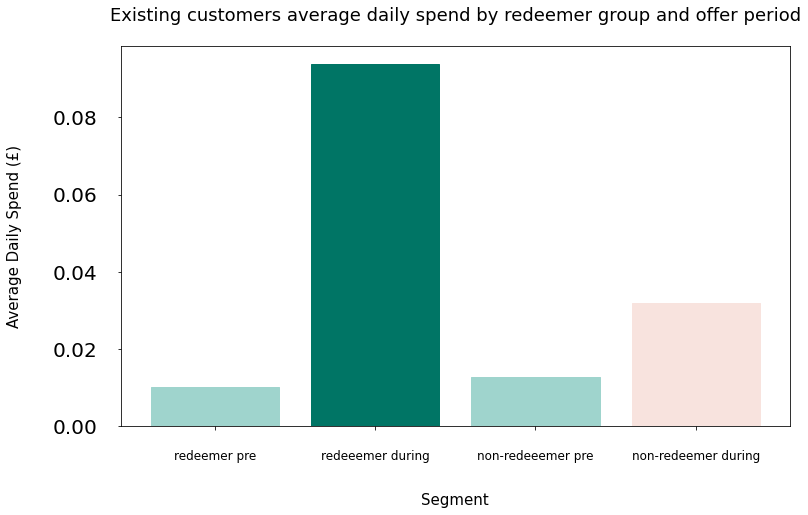

In [40]:
#quick plot of difference to help understanding
import matplotlib.pyplot as plt
plt.figure(figsize = (12,7))
rp = pre_spend_daily['total_amount']['median']['redeemer']/100
rd = during_spend_daily['total_amount']['median']['redeemer']/100
nrp = pre_spend_daily['total_amount']['median']['non-redeemer']/100
nrd = during_spend_daily['total_amount']['median']['non-redeemer']/100
x = ['redeemer pre','redeeemer during','non-redeeemer pre','non-redeemer during']
y = pd.Series([rp,rd,nrp,nrd])

chart = plt.bar(x,y)
chart[0].set_color('mint')
chart[1].set_color('green')
chart[2].set_color('mint')
chart[3].set_color('pink')
plt.title('Existing customers average daily spend by redeemer group and offer period', size = 18)
plt.ylabel('Average Daily Spend (£)', size = 15)
plt.xlabel('Segment', size = 15)

plt.show()

In [ ]:
#Is the difference significant?

In [ ]:
#should we be only looking at the spend after taking out the offer or for the wohle offer period?
#---> i think this is OK because if the offer was at the end, it woul dhave less time to take effect so have a smaller impact on result?
# but what id there was another offer than increased spend?
# ---> the non-redeeming frgroup could have also taken out this offer. 
#if after the offer, makes it more difficult to do redeemer/non-redeemer compariso

### New customers

- One of the biggest issue with comparing new customers in redeeming and non-redeeming group is the fact that new customers that are straight away very engaged with the offer may be predisposed to be more frequent before taking out thw offer being measured 
- We will take the new customers, average their daily value over the days for which we have their post spend 
- Our calculationgs don't imply causation! Certain NEW customers that may have been wanting to transact anyway may have taken out the offer

In [41]:
#want to find out the average number of days each new customer was active for in the measurement period
new_cust_first_txn = df_during[(df_during.new_segment=='new')&(df_during['count']==1)][['customer_id','date','offer_segment','offer_acq']].copy()
#work uot at what point in the measurement period, the new customer joined and began transacting 
new_cust_first_txn['days_active'] = (date_max - new_cust_first_txn['date']).astype('timedelta64[D]')
#what is the average active days for new customers in each redemption group 
new_days_active = new_cust_first_txn.groupby('offer_segment').agg({'days_active':['mean','median']})

In [43]:
#new customers spend 

#during offer period
during_spend_new = agg[agg['new_segment']=='new'].groupby('offer_segment').agg({'total_amount':['mean','median','sum']})
daily_avg_spend_new = during_spend_new['total_amount']['median']/new_days_active['days_active']['median']
daily_incr_new = (daily_avg_spend_new['redeemer'] - daily_avg_spend_new['non-redeemer'])/100
incr_spend_new = daily_incr_new*new_cust*during_days

print(f'For new customers, daily average incremetal spend was £{daily_incr_new:.2f} in the redeemer group')
print(f'')
print(f'Over the offer measurement period of {during_days} days, this is a total incremental spend of £{incr_spend_new:.2f} across the {new_cust:.0f} customers')
print(f'Or £{incr_spend_new/new_cust:.2f} per customer')

For new customers, daily average incremetal spend was £0.06 in the redeemer group

Over the offer measurement period of 331 days, this is a total incremental spend of £1355.65 across the 66 customers
Or £20.54 per customer


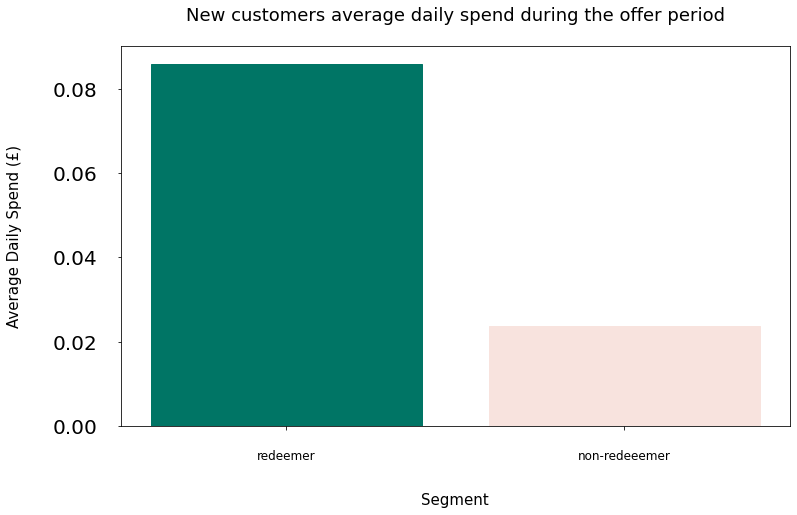

In [44]:
#quick plot of difference to help understanding

plt.figure(figsize = (12,7))
rd = daily_avg_spend_new['redeemer']/100
nrd = daily_avg_spend_new['non-redeemer']/100
x = ['redeemer','non-redeeemer']
y = pd.Series([rd,nrd])

chart = plt.bar(x,y)
chart[0].set_color('green')
chart[1].set_color('pink')
plt.title('New customers average daily spend during the offer period', size = 18)
plt.ylabel('Average Daily Spend (£)', size = 15)
plt.xlabel('Segment', size = 15)

plt.show()

### Total Revenue

In [45]:
total_incr_rev = incr_spend_new + incr_spend_total
total_incr_rev_cust = total_incr_rev/total_cust

print(f'The total incremental revenue from this offer over the measurement period is £{total_incr_rev:.0f}')
print(f'Per redeemer this is £{total_incr_rev_cust:.2f}')

The total incremental revenue from this offer over the measurement period is £4909
Per redeemer this is £31.27


### Total Cost

In [46]:
#= sum of redeemer price 
redeemer_receipts_during = df_during[df_during['offer_segment'] == 'redeemer']['receipt_id'].unique()

total_cost = (df_off[df_off['receipt_id'].isin(redeemer_receipts_during)]['price']*-1).sum()/100
total_cost_cust = total_cost/total_cust

print(f'The total discount given out over the offer measurement period is £{total_cost}')
print(f'Per redeemer this is £{total_cost_cust:.2f}')

The total discount given out over the offer measurement period is £884.3
Per redeemer this is £5.63


## ROI

In [47]:
ROI = (total_incr_rev/total_cost)
print(f'Return on investment is {ROI:.2f}')

Return on investment is 5.55


## ATV

In [49]:
v_metrics = agg2['ATV_offer_period']


ATV_redeemer = agg[agg['offer_segment']=='redeemer']['amount'].median()/100
ATV_non_redeemer = agg[agg['offer_segment']=='non-redeemer']['amount'].median()/100

print(f'Redeemers have an average transaction value of £{ATV_redeemer:.2f} during the offer period')
print(f'Non-redeemers have an average transaction value of £{ATV_non_redeemer:.2f} time during the offer period')
print('\n')

print('More detailed breakdown of ATV:')
print(v_metrics)
print('\n')

Redeemers have an average transaction value of £4.45 during the offer period
Non-redeemers have an average transaction value of £4.94 time during the offer period


More detailed breakdown of ATV:
offer_segment  new_segment
non-redeemer   existing       4.950000
               new            4.900000
redeemer       existing       4.444138
               new            4.513409
Name: ATV_offer_period, dtype: float64




## Basket Size

In [53]:
agg2

customer_id_nunique  frequency_mean  \
offer_segment new_segment                                        
non-redeemer  existing                    3119        4.442770   
              new                         3799        1.739668   
redeemer      existing                      91       13.208791   
              new                           66        7.984848   

                           frequency_median  total_amount_sum  \
offer_segment new_segment                                       
non-redeemer  existing                    2         7085775.0   
              new                         1         3451566.0   
redeemer      existing                    9          564400.0   
              new                         4          252657.0   

                           total_amount_mean  total_amount_median  \
offer_segment new_segment                                           
non-redeemer  existing           2271.809875               1060.0   
              new                 908.545933                605.0   
redeemer      existing           6202.197802               3105.0   
              new                3828.136364               2039.5   

                           amount_mean  amount_median  basket_size_mean  \
offer_segment new_segment                                                 
non-redeemer  existing      522.441467     495.000000          1.518285   
              new           525.017962     490.000000          1.547079   
redeemer      existing      447.939807     444.413793          1.688162   
              new           478.137018     451.340909          1.940060   

                           basket_size_median  ATF_offer_period  \
offer_segment new_segment                                         
non-redeemer  existing               1.333333                 2   
              new                    1.000000                 1   
redeemer      existing               1.666667                 9   
              new                    2.000000                 4   

                           ATV_offer_period  ACV_offer_period  \
offer_segment new_segment                                       
non-redeemer  existing             4.950000            10.600   
              new                  4.900000             6.050   
redeemer      existing             4.444138            31.050   
              new                  4.513409            20.395   

                           Basket_Size_offer_period  
offer_segment new_segment                            
non-redeemer  existing                     1.333333  
              new                          1.000000  
redeemer      existing                     1.666667  
              new                          2.000000

In [56]:
#now can summarise by segments the average basket size 

b_metrics = agg2['Basket_Size_offer_period']


ABS_redeemer = agg[agg['offer_segment']=='redeemer']['basket_size'].median()
ABS_non_redeemer = agg[agg['offer_segment']=='non-redeemer']['basket_size'].median()

print(f'Redeemers have an average basket size of {ABS_redeemer:.2f} during the offer period')
print(f'Non-redeemers have an average basket size of {ABS_non_redeemer:.2f} time during the offer period')
print('\n')

print('More detailed breakdown of Basket Size:')
print(b_metrics)
print('\n')

Redeemers have an average basket size of 1.67 during the offer period
Non-redeemers have an average basket size of 1.22 time during the offer period


More detailed breakdown of Basket Size:
offer_segment  new_segment
non-redeemer   existing       1.333333
               new            1.000000
redeemer       existing       1.666667
               new            2.000000
Name: Basket_Size_offer_period, dtype: float64


